In [182]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error

# 1. Load Data

In [2]:
path = "./data/sample.xlsx"
df = pd.read_excel(path, sheet_name = 'Hoja1')

In [89]:
type(df['FECHA'].values)

numpy.ndarray

In [76]:
df

,FECHA,OLEO CANOLA 500 ML (BOTELLAS),TAPA AZUL,TARROS,ETIQUETAS
0,2019-01-01,84,84,84,168
1,2019-01-08,74,74,74,148
2,2019-01-15,72,72,72,144
3,2019-01-22,95,95,95,190
4,2019-01-29,86,86,86,172
...,...,...,...,...,...
95,2020-10-27,187,187,187,374
96,2020-11-03,172,172,172,344
97,2020-11-10,194,194,194,388
98,2020-11-17,171,171,171,342


# 2. Add White Noise to MRP Timeseries

In [78]:
df['TAPA AZUL'] / df['OLEO CANOLA 500 ML (BOTELLAS)']

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
95    1.0
96    1.0
97    1.0
98    1.0
99    1.0
Length: 100, dtype: float64

<AxesSubplot:>

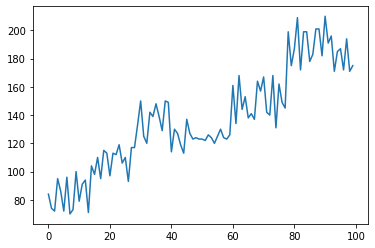

In [79]:
df['TAPA AZUL'].plot()

In [85]:
std_mrp_1 = 4
std_mrp_2 = 5
std_mrp_3 = 4.4

In [23]:
n = len(df['TAPA AZUL'])

mps = df['OLEO CANOLA 500 ML (BOTELLAS)'].values

# Create numpy arrays for the MRP Series with white noise
mrp_1 = df['TAPA AZUL'].values + np.random.normal(0, (std_mrp_1)**2, n)
mrp_2 = df['TARROS'].values + np.random.normal(0, (std_mrp_2)**2, n)
mrp_3 = df['ETIQUETAS'].values + np.random.normal(0, (std_mrp_3)**2, n)

# Calculate MRP/MPS Ratios
ratio_mrp_1 = mrp_1 / mps 
ratio_mrp_2 = mrp_2 / mps 
ratio_mrp_3 = mrp_3 / mps 

<AxesSubplot:>

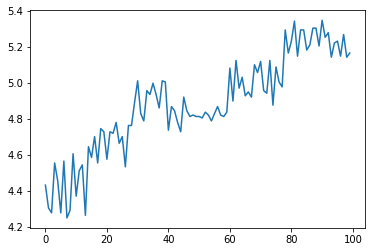

In [105]:
df['OLEO CANOLA 500 ML (BOTELLAS)'].apply(lambda x: np.log(x)).plot()

In [68]:
# Take days as string
days = df['FECHA'].apply(lambda x: x.strftime("%Y-%m-%d"))

In [92]:
days

0     2019-01-01
1     2019-01-08
2     2019-01-15
3     2019-01-22
4     2019-01-29
         ...    
95    2020-10-27
96    2020-11-03
97    2020-11-10
98    2020-11-17
99    2020-11-24
Name: FECHA, Length: 100, dtype: object

/tmp/ipykernel_2058/2509293891.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(days, rotation = 70)


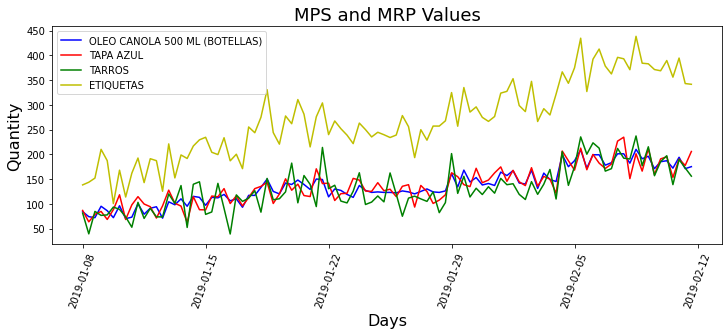

In [69]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(mps, color="b", label = df.columns[1])
ax.plot(mrp_1, color="r", label = df.columns[2])
ax.plot(mrp_2, color="g", label = df.columns[3])
ax.plot(mrp_3, color="y", label = df.columns[4])
ax.legend()
ax.set_title(f'MPS and MRP Values', fontsize=18)
ax.set_xticklabels(days, rotation = 70)
ax.set_ylabel('Quantity', fontsize=16)
ax.set_xlabel('Days', fontsize=16)
plt.show()

/tmp/ipykernel_2058/1523457442.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(days, rotation = 70)


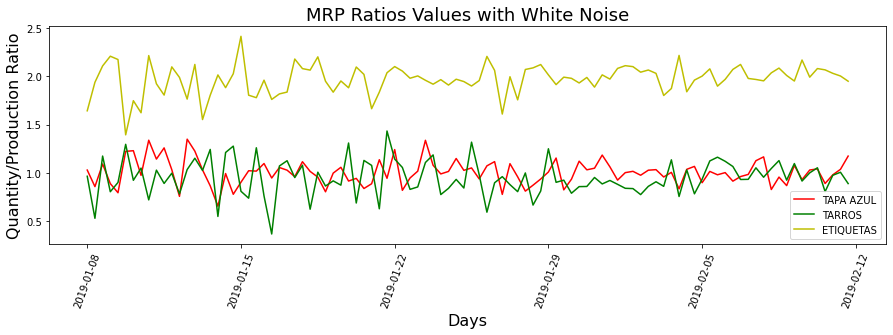

In [107]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(ratio_mrp_1, color="r", label = df.columns[2])
ax.plot(ratio_mrp_2, color="g", label = df.columns[3])
ax.plot(ratio_mrp_3, color="y", label = df.columns[4])
ax.legend()
ax.set_title(f'MRP Ratios Values with White Noise', fontsize=18)
ax.set_ylabel('Quantity/Production Ratio', fontsize=16)
ax.set_xlabel('Days', fontsize=16)
ax.set_xticklabels(days, rotation = 70)
plt.show()

# 3. Forecast

In [132]:
name = 'Andres'
signo = '!'
f'Hola {name} {signo}'

'Hola Andres !'

In [169]:
timeseries = {f'{df.columns[2]}' : ratio_mrp_1, 
              f'{df.columns[3]}' : ratio_mrp_2, 
              f'{df.columns[4]}' : ratio_mrp_3}

timeseries_original = {f'{df.columns[2]}' : mrp_1, 
                        f'{df.columns[3]}' : mrp_2, 
                        f'{df.columns[4]}' : mrp_3}

## 3.1 One-Shot Train-Test

In [144]:
def get_train_test(ts : np.ndarray, 
                   test_size : float = 0.2) -> list:
    n = len(ts)
    n_train = int(n*(1-test_size))
    n_test = n - n_train

    ts_train = ts[:n_train]
    ts_test = ts[n_train:]

    return ts_train, ts_test

In [183]:
max_p = 4 # AR
max_q = 4 # MA
d = 1 # Differencing level
sp = 4 # Level of Seasonality
test_size = 0.1

mapes = []
prediction_store = {}

for name, ts in timeseries.items():

    print(f"Training ARIMA Model for {name}")

    ts_train, ts_test = get_train_test(ts, test_size)

    #print("Test Data: ", ts_test)

    test_n = len(ts_test)
    fh = [x for x in range(1, test_n +1)] # list comprehension

    # --------------------- Model 1              ----------------#
    forecaster = AutoARIMA(sp=sp, d=d, 
                            max_p=max_p, 
                            max_q=max_q, 
                            suppress_warnings=True)  
    forecaster.fit(ts) 

    # Prediction of ratio
    prediction = forecaster.predict(fh=fh)
    # --------------------- -------------------- ----------------#

    # Transform to list 
    prediction = np.array(prediction).reshape(1,-1)[0]
    mps_prediction = np.array(mps[-test_n:])

    # Transfrom ratio to quantity using MPS
    mrp_prediction = prediction * mps_prediction

    # store prediction
    prediction_store[name] = mrp_prediction

    # actual values 
    ts_original = timeseries_original[name][-test_n:]

    print("Transformed Forecast values are: ", mrp_prediction)
    print("Actual Values are: ", ts_original)
    
    mape = mean_absolute_percentage_error(mrp_prediction , ts_original)
    mapes.append(mape)
    print(" MAPE is: ", mape)
    print("")

df_results = pd.DataFrame()
df_results['Timeseries_names'] = timeseries.keys()
df_results['mape'] = mapes


Training ARIMA Model for TAPA AZUL
Transformed Forecast values are:  [205.4947839  188.73897484 194.37532816 169.93532284 180.22994971
 184.50770749 170.72853028 193.70112934 166.47389661 172.47174402]
Actual Values are:  [201.07801956 166.02338277 211.33430505 159.19495107 190.7158056
 194.87099064 153.30133102 190.28434941 177.47721801 205.65041211]
 MAPE is:  0.07848297353124355

Training ARIMA Model for TARROS
Transformed Forecast values are:  [211.50971913 189.84956038 189.40099098 168.237899   181.0103768
 182.44471489 168.16949893 189.70075914 167.11803045 171.04851048]
Actual Values are:  [236.98916796 176.82091629 215.12833802 156.72873619 185.26914597
 197.07881867 138.73389889 189.31966166 172.32400286 155.80626066]
 MAPE is:  0.0794381537439792

Training ARIMA Model for ETIQUETAS
Transformed Forecast values are:  [419.92963114 398.17894266 402.26798088 355.82656658 376.03699846
 383.76399735 350.51130217 397.0193209  349.08212493 360.92714945]
Actual Values are:  [438.27583

In [184]:
df_results

,Timeseries_names,mape
0,TAPA AZUL,0.078483
1,TARROS,0.079438
2,ETIQUETAS,0.029878


In [185]:
pd.DataFrame(prediction_store)

,TAPA AZUL,TARROS,ETIQUETAS
0,205.494784,211.509719,419.929631
1,188.738975,189.849560,398.178943
2,194.375328,189.400991,402.267981
3,169.935323,168.237899,355.826567
4,180.229950,181.010377,376.036998
5,184.507707,182.444715,383.763997
6,170.728530,168.169499,350.511302
7,193.701129,189.700759,397.019321
8,166.473897,167.118030,349.082125
9,172.471744,171.048510,360.927149


# Test with ETS

In [186]:
max_p = 4 # AR
max_q = 4 # MA
d = 1 # Differencing level
sp = 4 # Level of Seasonality
test_size = 0.1

mapes = []
prediction_store = {}

for name, ts in timeseries.items():

    print(f"Training ARIMA Model for {name}")

    ts_train, ts_test = get_train_test(ts, test_size)

    #print("Test Data: ", ts_test)

    test_n = len(ts_test)
    fh = [x for x in range(1, test_n +1)] # list comprehension

    # --------------------- Model 2              ----------------#
    forecaster = AutoETS(sp=sp)  
    forecaster.fit(ts) 
    # Prediction of ratio
    prediction = forecaster.predict(fh=fh)
    # --------------------- -------------------- ----------------#


    # Transform to list 
    prediction = np.array(prediction).reshape(1,-1)[0]
    mps_prediction = np.array(mps[-test_n:])

    # Transfrom ratio to quantity using MPS
    mrp_prediction = prediction * mps_prediction

    # store prediction
    prediction_store[name] = mrp_prediction

    # actual values 
    ts_original = timeseries_original[name][-test_n:]

    print("Transformed Forecast values are: ", mrp_prediction)
    print("Actual Values are: ", ts_original)
    
    mape = mean_absolute_percentage_error(mrp_prediction , ts_original)
    mapes.append(mape)
    print(" MAPE is: ", mape)
    print("")

df_results = pd.DataFrame()
df_results['Timeseries_names'] = timeseries.keys()
df_results['mape'] = mapes


Training ARIMA Model for TAPA AZUL
Transformed Forecast values are:  [211.33141228 192.21095116 197.24265146 172.08415    186.17291081
 188.18559093 173.09049005 195.22997134 172.08415    176.10951023]
Actual Values are:  [201.07801956 166.02338277 211.33430505 159.19495107 190.7158056
 194.87099064 153.30133102 190.28434941 177.47721801 205.65041211]
 MAPE is:  0.07297748746989866

Training ARIMA Model for TARROS
Transformed Forecast values are:  [199.46244517 181.41584299 186.16494882 162.41941964 175.71691598
 177.61655832 163.3692408  184.26530649 162.41941964 166.21870431]
Actual Values are:  [236.98916796 176.82091629 215.12833802 156.72873619 185.26914597
 197.07881867 138.73389889 189.31966166 172.32400286 155.80626066]
 MAPE is:  0.08698694252328652

Training ARIMA Model for ETIQUETAS
Transformed Forecast values are:  [419.38855734 381.44387834 391.42932018 341.50211098 369.46134813
 373.45552487 343.49919935 387.43514345 341.50211098 349.49046445]
Actual Values are:  [438.275

In [187]:
df_results

,Timeseries_names,mape
0,TAPA AZUL,0.072977
1,TARROS,0.086987
2,ETIQUETAS,0.028631


In [188]:
pd.DataFrame(prediction_store)

,TAPA AZUL,TARROS,ETIQUETAS
0,211.331412,199.462445,419.388557
1,192.210951,181.415843,381.443878
2,197.242651,186.164949,391.429320
3,172.084150,162.419420,341.502111
4,186.172911,175.716916,369.461348
5,188.185591,177.616558,373.455525
6,173.090490,163.369241,343.499199
7,195.229971,184.265306,387.435143
8,172.084150,162.419420,341.502111
9,176.109510,166.218704,349.490464
